In [9]:
"""
Philosophy of this network:
    The goal that I had while writing this was for me to cement my understanding of the basic fully connected feed-forward network.
    My original implementation was quite slow, as it was not taking advantage of numpy vectorization - this version does. You can compare
    the previous version of this file to this one (filename nn.py, commit 9cb3da3ce582e940ed862f95930879c8be1721d1), and see the 
    significant training speed differences. I will say, adding vectorization makes the code less readable (and also increases the
    required memory) as I had to pad all vectors and matricies with zeros so each set of data had the same shape (and therefore it could be vectorized).
"""

import numpy as np
from matplotlib.pyplot import imshow

In [5]:
class FFNN:
    def __init__(self, layers, hs, cost_fcn):
        assert len(hs) == len(layers) - 1
        self.layers = layers
        self.hs = hs
        self.cost_fcn = cost_fcn
        self.max_row, self.max_col = self.get_weights_matrix_max_shape()
        self.weights, self.biases = self.make_network()

    def make_network(self, random=True):
        """We padd the weight matricies to the largest weight matrix, so we can vectorize everything and be quick"""
        layer_arr = self.layers
        max_row, max_col = self.max_row, self.max_col
        assert len(layer_arr) > 2

        weights = []
        biases = []

        layer_iter = iter(layer_arr)
        prev_dim = layer_iter.__next__()

        for i, dim in enumerate(layer_iter):
            if random:
                bound = 4 * np.sqrt(6) / np.sqrt(layer_arr[i] + layer_arr[i + 1])
                weight = np.random.uniform(low=-bound, high=bound, size=(dim, prev_dim))
                bias = np.random.uniform(low=-bound, high=bound, size=(dim, 1))
                padded_weights = self.pad_edges(
                    weight, max_row - dim, max_col - prev_dim
                )
                padded_biases = self.pad_edges(bias, max_row - dim, 0)
            else:
                padded_weights = np.zeros((max_row, max_col))
                padded_biases = np.zeros((max_row, 1))

            weights.append(padded_weights)
            biases.append(padded_biases)
            prev_dim = dim

        return weights, biases

    def feed_forward(self, xs):
        """
        Feed-forward through the entire network
        xs has to be of shape (batch_size, num_rows, 1)
        - x, z, a are all vectors of inputs, outputs, and linear outputs at layers
        """
        col_xs = np.copy(xs)

        # If xs is not a batch, make it a batch for the ff
        if len(col_xs.shape) == 2:
            col_xs = col_xs.reshape(1, col_xs.shape[0], col_xs.shape[1])

        batch_size, num_rows, _ = col_xs.shape
        z = self.pad_edges(col_xs, self.max_row - num_rows, 0)
        # make ays and zs a uniform size; that way we can do vectorization
        ays = np.zeros((batch_size, self.max_row, len(self.layers) - 1))
        zs = np.zeros((batch_size, self.max_row, len(self.layers)))

        zs[..., 0] = np.squeeze(z, axis=-1)
        for i, W in enumerate(self.weights):
            layer_out = zs[..., i, np.newaxis]
            a = np.dot(W, layer_out) + self.biases[i]
            # shape of a is (batch_size, num_rows, 1) - needs to be (batch_size, num_rows) for this slice of ays
            ays[..., i] = np.squeeze(a, axis=-1)
            zs[..., i + 1] = np.squeeze(self.hs[i].f(a), axis=-1)

        y = zs[..., -1, np.newaxis]
        return y, ays, zs

    def back_prop(self, xs, ts, batch=False):
        """
        xs,ts are lists of vectors (ts are targets for training i.e. true output given input x)
        """
        grads, biases = self.make_network(random=False)
        ys, ays, zs = self.feed_forward(xs)
        # delta_L: derivative of Cost fcn w.r.t. zs times derivative of nonlinear fcn of final layer
        ts = ts.reshape(-1, self.layers[-1], 1)
        ts = self.pad_edges(ts, self.max_row - self.layers[-1], 0)
        delta = self.cost_fcn.deriv(ts, ys) * self.hs[-1].deriv(
            ays[..., -1, np.newaxis]
        )

        """ dC/dw_jk = a_k * d_j """
        batch_weights = np.einsum("bko, bjo -> bjk", zs[..., -2, np.newaxis], delta)

        grads[-1] = np.sum(batch_weights, axis=0)
        biases[-1] = np.sum(delta, axis=0)
        # back propogate through the layers
        for l in range(2, len(self.layers)):
            nonlinear_deriv = self.hs[-l].deriv(ays[..., -l, np.newaxis])
            delta = (
                np.einsum("jk, bjo -> bko", self.weights[-l + 1], delta)
                * nonlinear_deriv
            )
            batch_weights = np.einsum(
                "bko, bjo -> bjk", zs[..., -l - 1, np.newaxis], delta
            )

            grads[-l] = np.sum(batch_weights, axis=0)
            biases[-l] = np.sum(delta, axis=0)

        return grads, biases

    def learn(self, xs, ys, epochs, batch_size, lr):
        """
        xs/ys is the input/output data, xs_val/ys_val is input/output validation, epochs is
        the number of batches to train, batch size is the number of input/outputs to
        use in each batch, and lr is learning rate
        """
        for epoch in range(epochs):
            random_indicies = np.random.choice(xs.shape[0], size=batch_size)
            self.mini_batch(xs[random_indicies, :], ys[random_indicies, :], lr)

            ys_out_test, _, _ = self.feed_forward(xs)
            ys_out_val, _, _ = self.feed_forward(xs_val)

            train_loss = np.mean(self.cost_fcn.f(ys, ys_out_test[:, :1]))

            if epoch % 500 == 0:
                print(f"epoch {epoch} \t train loss {train_loss:.3f}")

    def mini_batch(self, batch_xs, batch_ys, lr):
        """
        batch_xs is the batch of inputs, batch_ys is batch of outputs, lr is learning rate
        """
        weight_grads, bias_grads = self.back_prop(batch_xs, batch_ys)

        self.weights = [
            w - lr * weight_grad for w, weight_grad in zip(self.weights, weight_grads)
        ]
        self.biases = [
            b - lr * bias_grad for b, bias_grad in zip(self.biases, bias_grads)
        ]

    def get_weights_matrix_max_shape(self):
        max_row = max_col = 0
        for dim, prev_dim in zip(self.layers[1:], self.layers):
            max_row, max_col = max(max_row, dim), max(max_col, prev_dim)
        return max_row, max_col

    def pad_last_2_dims(self, M, bottom_pad, right_pad):
        out = [(0, 0) for _ in range(len(M.shape) - 2)]
        out.append((0, bottom_pad))
        out.append((0, right_pad))
        return tuple(out)

    def pad_edges(self, M, bottom_pad, right_pad):
        pad_tuple = self.pad_last_2_dims(M, bottom_pad, right_pad)
        return np.pad(M, pad_tuple, "constant", constant_values=0)

In [16]:
def mnist():
    def load_data(fname):
        data_folder = "mnist_data/"
        with open(data_folder + fname, "rb") as f:
            data = f.read()
        return np.frombuffer(data, dtype=np.uint8)

    x_train = load_data("train-images-idx3-ubyte")
    y_train = load_data("train-labels-idx1-ubyte")
    x_test = load_data("t10k-images-idx3-ubyte")
    y_test = load_data("t10k-labels-idx1-ubyte")

    return (
        x_train[16:].reshape((-1, 28, 28)),
        _get_one_hot(y_train[8:].reshape((-1, 1)), 10),
        x_test[16:].reshape((-1, 28, 28)),
        _get_one_hot(y_test[8:].reshape((-1, 1)), 10),
    )


def _get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape((targets.shape[0], nb_classes))

In [19]:
X_train, Y_train, X_test, Y_test = mnist()
Y_train.shape

(60000, 10)

(<matplotlib.image.AxesImage at 0x11b26aca0>, 7)

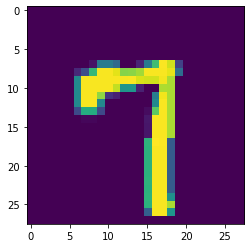

In [22]:
n = 2344

imshow(X_train[n]), np.argmax(Y_train[n])